Import Packages

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

import numpy as np
import pandas as pd

File Path

In [2]:
Audio_train = 'data/npy/Apr9/train_mfcc_fold8_50_delta_delta.npy'
Audio_val = 'data/npy/Apr9/val_mfcc_fold8_50_delta_delta.npy'
Audio_test = 'data/npy/Apr9/test_mfcc50_delta_delta.npy'


Quote: https://colab.research.google.com/drive/134NRf4PAR1CuQejf6q3DTDZNaFklR8NY?usp=sharing

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.cost = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

<b>Data Preprocessing <br></b>
Z-Normalization

In [4]:
################# set to your own path ##############
Features_Labels = np.load(Audio_train)
test_Features = np.load(Audio_test)
Val_Features_Labels = np.load(Audio_val)
################# set to your own path ##############


no_instances = Features_Labels.shape[0]
no_classes = 10
no_features = Features_Labels.shape[1] - no_classes
Features = Features_Labels[:,0:no_features]
Labels_array = Features_Labels[:,no_features:Features_Labels.shape[1]]
Labels = []
for i in Labels_array:
    Labels.append(np.where(i == max(i))[0][0])

Val_Features = Val_Features_Labels[:,0:no_features]
Val_Labels_array = Val_Features_Labels[:,no_features:Features_Labels.shape[1]]
Val_Labels = []
for i in Val_Labels_array:
    Val_Labels.append(np.where(i == max(i))[0][0])
print (Features.shape, Labels_array.shape, Val_Features.shape, Val_Labels_array.shape)#, test_Features.shape)



############### Normalization ###################
mean = np.mean(Features, axis=0, keepdims=True)
std = np.std(Features, axis=0, ddof=1, keepdims=True)

# Z-normalize each row
Features_normalized = (Features - mean) / std

# mean = np.mean(test_Features, axis=1, keepdims=True)
# std = np.std(test_Features, axis=1, ddof=1, keepdims=True)

# Z-normalize each row
test_Features_norm = (test_Features - mean) / std
test_Features_norm

Val_Features_norm = (Val_Features - mean) / std
Val_Features_norm
############### Normalization ####################

(800, 300) (800, 10) (100, 300) (100, 10)


array([[-0.70532743,  0.50288148, -0.15561555, ...,  0.71970385,
         0.24446883,  0.03173463],
       [-0.9106413 ,  1.15877521,  0.53727727, ...,  1.76773419,
         1.48372101,  1.84433382],
       [-1.45079868,  0.20518245,  1.25889523, ..., -0.19996044,
        -0.65831403, -0.989708  ],
       ...,
       [ 0.79297733, -0.72589192, -0.84976611, ..., -0.80418456,
        -0.78035322, -0.7266562 ],
       [ 0.58603427, -0.23799363, -0.24808601, ..., -0.377274  ,
        -0.72369873, -0.44429014],
       [-0.60684619, -0.42799432, -0.15083106, ..., -0.54413445,
        -0.3896985 , -0.76947425]])

Build the MLP

In [19]:
#scaler = StandardScaler() # not necessary if you do normalization before

train_dataset = TensorDataset(torch.tensor(Features_normalized, dtype=torch.float32), torch.tensor(Labels, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(Val_Features_norm, dtype=torch.float32), torch.tensor(Val_Labels, dtype=torch.long))

batch_size = 40
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

# input layer
# number of features
input_size = Features_normalized.shape[1]
# number of hidden layer's nodes
hidden_size = 64
output_size = Labels_array.shape[1]

model = MLP(input_size, hidden_size, output_size)
print (model)

optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.001)


MLP(
  (fc1): Linear(in_features=300, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (cost): CrossEntropyLoss()
)


Train the MLP

100%|██████████| 1000/1000 [00:23<00:00, 42.91it/s]


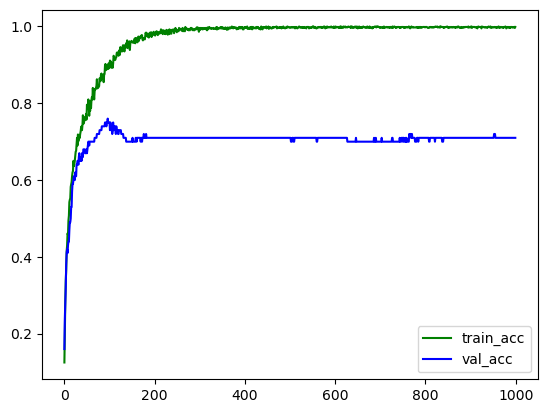

In [20]:
Epochs = 1000
train_acc = []
val_acc = []
for ep in tqdm(range(Epochs)):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        # remove the gradient from the preious batch to remove bias
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = model.cost(outputs,targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_acc.append(correct_train/total_train)
    #print (f"Epoch{ep+1}: Train loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc: .2f}")
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = model.cost(outputs, targets)
            val_loss += loss.item()
            _,predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_acc.append(correct_val/total_val)
    #print (f"Epoch{ep+1}: Val loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc: .2f}")

train_acc = np.array(train_acc)
val_acc = np.array(val_acc)
plt.plot(range(Epochs), train_acc, 'g', label = 'train_acc')
plt.plot(range(Epochs), val_acc, 'b', label = 'val_acc')
plt.legend()

Get the Prediction

In [21]:
test_tensor = torch.tensor(test_Features_norm, dtype = torch.float32)

with torch.no_grad():
    output = model(test_tensor)
    torch.max(outputs, 1)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)

genra = ['blues', ' classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
kaggle = pd.read_csv('data/data/test/list_test.txt', header = None)
for i in tqdm(range(100)):
    kaggle.loc[i,'class'] = genra[predicted_class[i]]

kaggle.to_csv('CSV/kaggle_mfcc50_delta_delta_MLP_1000.csv')
kaggle

100%|██████████| 100/100 [00:00<00:00, 9945.00it/s]


,0,class
0,test.00596.au,hiphop
1,test.02436.au,reggae
2,test.02930.au,blues
3,test.03364.au,country
4,test.03550.au,country
...,...,...
95,test.95763.au,metal
96,test.96483.au,reggae
97,test.97080.au,classical
98,test.97638.au,country


In [87]:
predicted_class

tensor([4, 8, 1, 2, 2, 5, 8, 2, 1, 6, 5, 1, 2, 4, 4, 2, 5, 9, 0, 1, 8, 3, 7, 7,
        3, 9, 1, 2, 4, 4, 6, 8, 9, 1, 4, 3, 9, 3, 2, 1, 9, 6, 5, 4, 1, 4, 6, 1,
        8, 8, 7, 6, 5, 1, 7, 1, 6, 6, 9, 7, 2, 7, 8, 0, 7, 3, 4, 2, 9, 4, 7, 3,
        1, 5, 1, 8, 6, 8, 9, 4, 3, 2, 5, 6, 6, 3, 7, 1, 2, 5, 8, 3, 5, 2, 1, 6,
        8, 1, 2, 3])